> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [2]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html




<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
import pandas as pd
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')
df.head()






,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# show number of patients and their charachteristics
df.shape

(110527, 14)

In [4]:
#basic information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [4]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

# we do not need some columns, so we will drop them

df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis = 1, inplace = True)
df.head()




,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
df.rename(columns={'No-show' : 'No_show'}, inplace = True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
df.rename(columns={'Hipertension' : 'Hypertension'}, inplace = True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


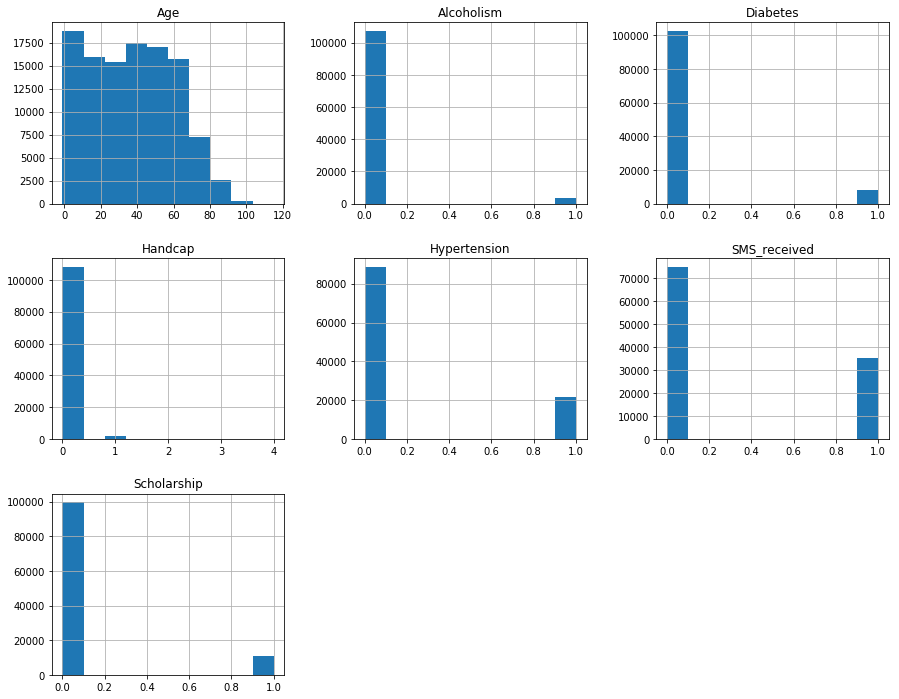

In [7]:
df.hist(figsize= (15,12)); #visualization of dataset

In [8]:
show = df.No_show == 'No'
noshow = df.No_show == 'Yes'

In [9]:
df[show].count()

Gender           88208
Age              88208
Neighbourhood    88208
Scholarship      88208
Hypertension     88208
Diabetes         88208
Alcoholism       88208
Handcap          88208
SMS_received     88208
No_show          88208
dtype: int64

In [10]:
df[noshow].count()

Gender           22319
Age              22319
Neighbourhood    22319
Scholarship      22319
Hypertension     22319
Diabetes         22319
Alcoholism       22319
Handcap          22319
SMS_received     22319
No_show          22319
dtype: int64

<p>the number is 4 times</p>

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Replace this header name!)

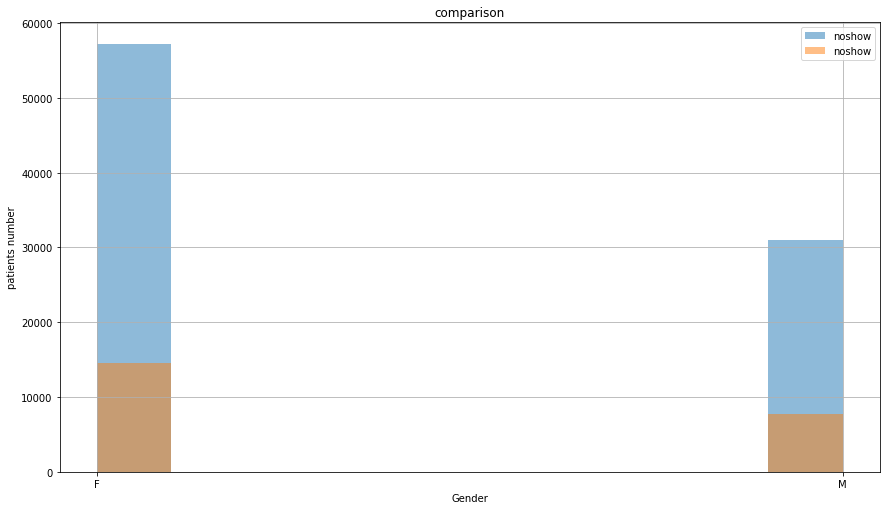

In [11]:

plt.figure(figsize=[14.70,8.27])
df.Gender[show].hist(alpha = 0.5, label = 'noshow')
df.Gender[noshow].hist(alpha = 0.5, label = 'noshow')
plt.legend()
plt.title('comparison')
plt.xlabel('Gender')
plt.ylabel('patients number');

In [12]:
print(df.Gender[show].value_counts())
print(df.Gender[noshow].value_counts())

F    57246
M    30962
Name: Gender, dtype: int64
F    14594
M     7725
Name: Gender, dtype: int64


In [13]:
df.groupby('Gender').No_show.value_counts()

Gender  No_show
F       No         57246
        Yes        14594
M       No         30962
        Yes         7725
Name: No_show, dtype: int64

gender is insignificant


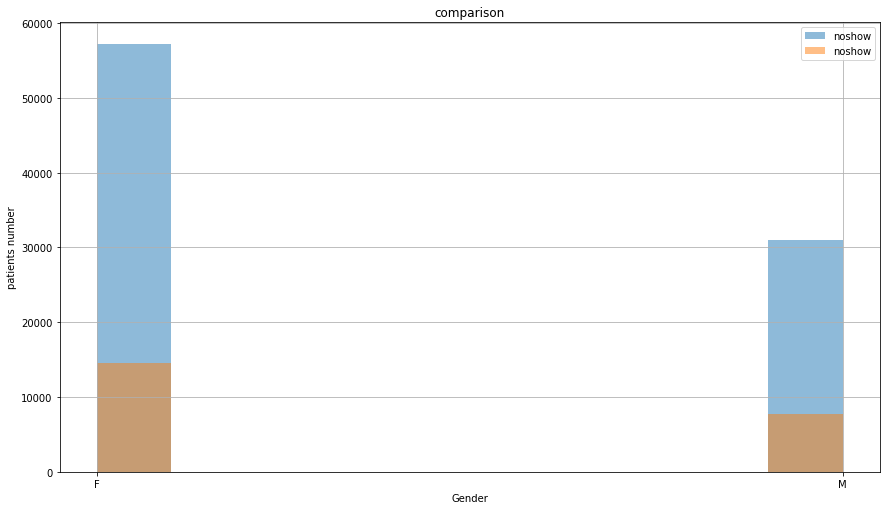

In [14]:
plt.figure(figsize=[14.70,8.27])
df.Gender[show].hist(alpha = 0.5, label = 'noshow')
df.Gender[noshow].hist(alpha = 0.5, label = 'noshow')
plt.legend()
plt.title('comparison')
plt.xlabel('Gender')
plt.ylabel('patients number');

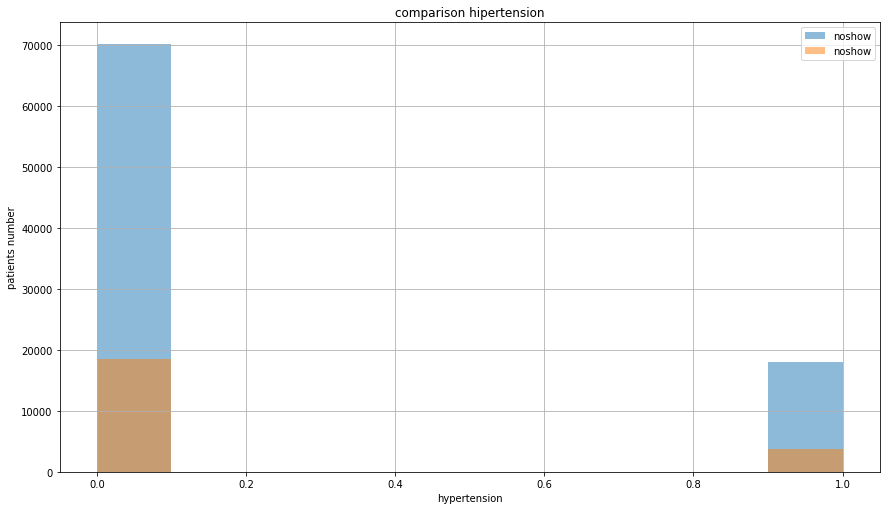

In [15]:
plt.figure(figsize=[14.70,8.27])
df.Hypertension[show].hist(alpha = 0.5, label = 'noshow')
df.Hypertension[noshow].hist(alpha = 0.5, label = 'noshow')
plt.legend()
plt.title('comparison hipertension')
plt.xlabel('hypertension')
plt.ylabel('patients number');

insignificant hypertension.

In [16]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df.rename(columns = {'PatientId':'Patient_id', 'AppointmentID':'Appointment_id', 'ScheduledDay':'Scheduled_day',\
                     'AppointmentDay':'Appointment_day', 'No-show':'No_show'}, inplace = True)



### Research Question 2  (Replace this header name!)

In [17]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.


> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

### Limitations
> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

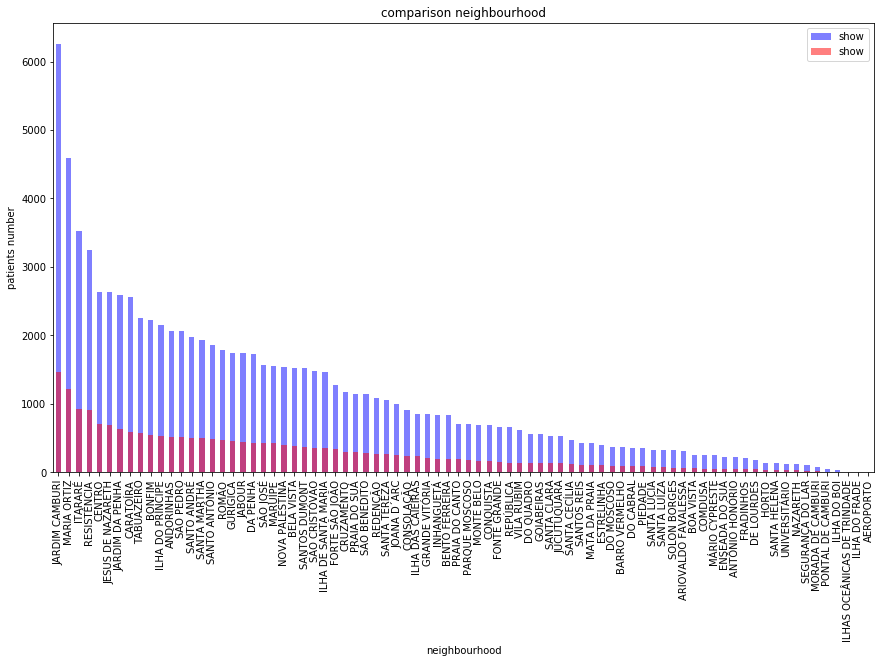

In [18]:
plt.figure(figsize=[14.70,8.27])
df.Neighbourhood[show].value_counts().plot (kind = 'bar', alpha = 0.5, color= 'blue', label = 'show')
df.Neighbourhood[noshow].value_counts().plot (kind = 'bar', alpha = 0.5, color= 'red', label = 'show')
plt.legend()
plt.title('comparison neighbourhood')
plt.xlabel('neighbourhood')
plt.ylabel('patients number');


Neighbourhood is important significant.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])